Importation des bibliotèques nécessaires

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from collections import deque,namedtuple

!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install pygame

import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import RecordVideo
import pygame

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://security.ubuntu.c

Première implémentation de l'environnement CartPole-v1

In [ ]:

import gym
env = gym.make('CartPole-v1', render_mode="rgb_array")
env.seed(0)

print(env.action_space.n) #le nombre d'action possible 2 mouvement à droit ou à gauche
print(env.observation_space.shape[0])  # nombre d'observation 4

2
4


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


# 2 Implematation d'un réseau de neuron DQN
2.1 Experience replay



Dans cette partie on va implementez un buffer circulaire d'experience Replay et on va ajouter une methode que l'on va définit (sample) qui va tirer aléatoireemnt un lot d'experience avec une taille donnée en paramètre.

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))
        
   # définition de la méthode sample pour un tir aléatoire d'experience
    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) 
        return random.sample(self.memory,batch_size)

    def __len__(self):
        return len(self.memory)

Maintenant on va implementer un réseaux de neuron qui prend comme entrée la dimension de l'espace d'etat et le nombre de sortie corresposnd au dimesion de l'espace d'action .

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                  nn.Linear(state_space_dim,64), # première couche prend la dimension d'état comme nombre d'entrée
                  nn.ReLU(),
                  nn.Linear(64,64*2),
                  nn.ReLU(),
                  nn.Linear(64*2,action_space_dim) # la dernière couche prende la dimension de l'espace d'action comme nombre de sortie pour notre cas on 2
                )

    def forward(self, x):
        x = x.to(device)
        return self.linear(x)

On va définir la methode epsilon_greedy pour mettre en ouvre le pourcentage de l'exploration et de l'exploitation

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('la valeur doit être entre  0 et 1')
                
    # l'Evaluation de sortie  de réseau à partir de l'etat actulle
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) 
        net_out = net(state)

    # prend la meilleur action (argmax of the network output)
    best_action = int(net_out.argmax())

    # le nombre des actions possibles à partie de la sortie de notre réseau
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions (this list includes all the actions but the optimal one)
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
  
        action = random.choice(non_optimal_actions)
    else:
        # Selection  de la meuilleur action 
        action = best_action
        
    return action, net_out.cpu().numpy()

In [ ]:
def choose_action_softmax(net, state):
    
    #Evaluation du réseau de neuron à partir de l'état actuelle
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Application du softmax pour avoir la meuilleur action qui maximise les valeurs de Q
    softmax_out = nn.functional.softmax(net_out, dim=0).cpu().numpy()
                
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions,p=softmax_out)
    
    return action, net_out.cpu().numpy()

Text(0, 0.5, 'Exploration profile')

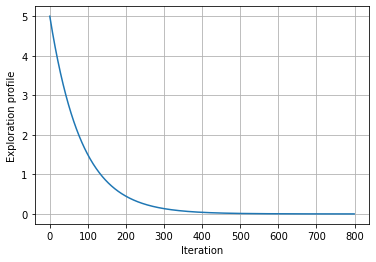

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 800
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]


plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile')

Maintenant on va définir le loss de DQN LDQN

In [ ]:
# environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment 

state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

# Set random seeds
torch.manual_seed(0)
np.random.seed(0)

gamma = 0.99  # deifnition de la coeifficient d'attenuation po
replay_memory_capacity = 10000   
lr = 1e-3  # défintion du taux d'appprentissage
target_net_update_steps = 10   
batch_size = 256   
bad_state_penalty = 0   
min_samples_for_training = 1000   

# replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

# policy network
policy_net = DQN(state_space_dim, action_space_dim).to(device)

# target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

loss_fn = nn.SmoothL1Loss()

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


Le but de cette partie est de renforcer l'algorithme à suivre l'equation de bellman en posant un erreur entre le cible qui est representer par l'equation de Bellman et la valeur prédite par le reseau DQN avec la retropagation de cette erreur à chaque epoche pour faire la mis à jour des paramètres et ameliorer le performance 

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # tirer de la replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    #Creation des  tenseurs pour chaque element du batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32, device=device)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64, device=device)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32, device=device)

    
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32, device=device) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Calcule les valeurs de Q
    policy_net.train()
    q_values = policy_net(states)

    # selectionner les valeurs de Q qui correspond à l'action pris 
    state_action_values = q_values.gather(1, actions.unsqueeze(1).cuda())

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size, device=device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0].detach()

    # calcule de la valeur cible selon l'équation de Bellman
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1)

    loss = loss_fn(state_action_values, expected_state_action_values)
    optimizer.zero_grad()
    loss.backward() # retropropagation de l'erreur 

  
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [ ]:
!pip install --user scikit-image OpenEXR==1.3.2
!pip install --user torch==1.7.0+cu110 torchvision==0.8.1+cu110 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for OpenEXR: filename=OpenEXR-1.3.2-cp38-cp38-linux_x86_64.whl size=191789 sha256=6dae33cf20f436f45728f95712bfdb591500b19f7177b55523fbc23653bbdc76
  Stored in directory: /root/.cache/pip/wheels/0a/10/25/9e32a4b1313a410a3210aea47a0fe60c8a738da2ef55419cd7
Successfully built OpenEXR
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████▌        | 834.1 MB 1.3 MB/s eta 0:03:52tcmalloc: large alloc 1147494400 bytes == 0x397da000 @  0x7f2f473d7615 0x5d631c 0x51e4f1 0x51e67b 0x4f7585 0x49ca7c 0x4fdff5 0x49caa1 0x4fdff5 0x49ced5 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x5d7c18 0x5d9412 0x586636 0x5d813c 0x55f3fd 0x55e571 0x5d7cf1 0x49ced5 0x55e571 0x5d7cf1 0x49ec69 0x5d7c18 0x49ca7c 0x4fdff5 0x49ced5
     |████████████████████

In [ ]:

env = gym.make('CartPole-v1',render_mode="rgb_array") 
env.seed(0) 

env = RecordVideo(env,'./virer' ) # enregistrer un video chaque 100 episode dans le repertoire que l'on va nommmer ./virer

plotting_rewards=[]

for episode_num, tau in enumerate(tqdm(exploration_profile)):
    state = env.reset()
    score = 0
    done = False
    #env.reset()

    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state)
      
      next_state, reward, done, info = env.step(action)

      # Update the final score (-1 for each step)
      score += reward

      if done:  
          reward += bad_state_penalty
          next_state = None
      
      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)
                    

      # Visually render the environment 
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    
    plotting_rewards.append(score)
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score}") # Print the final score

env.close()


  0%|          | 0/800 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 9.0
EPISODE: 2 - FINAL SCORE: 18.0
EPISODE: 3 - FINAL SCORE: 19.0
EPISODE: 4 - FINAL SCORE: 11.0
EPISODE: 5 - FINAL SCORE: 11.0
EPISODE: 6 - FINAL SCORE: 25.0
EPISODE: 7 - FINAL SCORE: 33.0
EPISODE: 8 - FINAL SCORE: 19.0
EPISODE: 9 - FINAL SCORE: 15.0
EPISODE: 10 - FINAL SCORE: 27.0
Updating target network...
EPISODE: 11 - FINAL SCORE: 18.0
EPISODE: 12 - FINAL SCORE: 23.0
EPISODE: 13 - FINAL SCORE: 18.0
EPISODE: 14 - FINAL SCORE: 32.0
EPISODE: 15 - FINAL SCORE: 17.0
EPISODE: 16 - FINAL SCORE: 29.0
EPISODE: 17 - FINAL SCORE: 20.0
EPISODE: 18 - FINAL SCORE: 22.0
EPISODE: 19 - FINAL SCORE: 15.0
EPISODE: 20 - FINAL SCORE: 33.0
Updating target network...
EPISODE: 21 - FINAL SCORE: 12.0
EPISODE: 22 - FINAL SCORE: 41.0
EPISODE: 23 - FINAL SCORE: 16.0
EPISODE: 24 - FINAL SCORE: 20.0
EPISODE: 25 - FINAL SCORE: 29.0
EPISODE: 26 - FINAL SCORE: 22.0
EPISODE: 27 - FINAL SCORE: 20.0
EPISODE: 28 - FINAL SCORE: 22.0
EPISODE: 29 - FINAL SCORE: 12.0
E

<ipython-input-9-bbd9af9df284>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  states      = torch.tensor([s[0] for s in batch], dtype=torch.float32, device=device)


RuntimeError: ignored